# Real Estate Price Predictions

Notebook com predição do preço por unidade de área de casas.  
Dataset extraído do kaggle (https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction)

In [1]:
# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from stepwise_process.statsmodels import stepwise
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Visualizando os dados
df = pd.read_csv('Real estate.csv')

In [3]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#

## Data Cleaning

In [4]:
# Drop da primeira coluna
df.drop('No', axis=1, inplace = True)

In [5]:
# Renomeando as colunas
df.rename(columns= {'X1 transaction date': 'Data Transacao',
                    'X2 house age': 'Idade casa',
                    'X3 distance to the nearest MRT station': 'Distancia da estacao metro',
                    'X4 number of convenience stores': 'Numero lojas conveniencia',
                    'X5 latitude': 'Latitude',
                    'X6 longitude': 'Longitude',
                    'Y house price of unit area': 'Preco por unidade de area'}, inplace=True)

In [6]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
# Verificação de registros duplicados
df.duplicated().sum() # Não há

0

In [8]:
# Verificação de valores ausentes
df.isna().sum() # Não há

Data Transacao                0
Idade casa                    0
Distancia da estacao metro    0
Numero lojas conveniencia     0
Latitude                      0
Longitude                     0
Preco por unidade de area     0
dtype: int64

## Pré-Processamento de Dados

In [9]:
# Separando a coluna "Data Transacao" em ano e mês.
ano_mes = df['Data Transacao'].apply(lambda x: str(x).split('.'))

ano = [year[0] for year in ano_mes]
mes = [month[1] for month in ano_mes]

df['Ano Transacao'] = ano
df['Mes Transacao'] = mes


In [10]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area,Ano Transacao,Mes Transacao
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,2012,917
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,2012,917
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,2013,583
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,2013,5
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,2012,833


In [11]:
# Mudar posiçao das colunas de data e remover a inicial
mudar_posicao1 = df.pop('Ano Transacao')
mudar_posicao2 = df.pop('Mes Transacao')
remove_coluna = df.pop('Data Transacao')

df.insert(0, 'Ano Transacao', mudar_posicao1)
df.insert(1, 'Mes Transacao', mudar_posicao2)

In [12]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,5,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,833,5.0,390.56840,5,24.97937,121.54245,43.1


In [13]:
# Agora é preciso adequar a coluna 'Mes Transacao' para ficar de 0 a 12 (Jan-Dez)
df['Mes Transacao'] = [int(mes)/83.33 for mes in df['Mes Transacao']]
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,11.004440,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,11.004440,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,6.996280,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,0.060002,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,9.996400,5.0,390.56840,5,24.97937,121.54245,43.1


In [14]:
for i in range(0, len(df)):
    if df['Mes Transacao'][i] < 1:
         df['Mes Transacao'][i] = 1
    elif df['Mes Transacao'][i] < 2:
         df['Mes Transacao'][i] = 2
    elif df['Mes Transacao'][i] < 3:
         df['Mes Transacao'][i] = 3
    elif df['Mes Transacao'][i] < 4:
         df['Mes Transacao'][i] = 4
    elif df['Mes Transacao'][i] < 5:
         df['Mes Transacao'][i] = 5
    elif df['Mes Transacao'][i] < 6:
         df['Mes Transacao'][i] = 6
    elif df['Mes Transacao'][i] < 7:
         df['Mes Transacao'][i] = 7
    elif df['Mes Transacao'][i] < 8:
         df['Mes Transacao'][i] = 8
    elif df['Mes Transacao'][i] < 9:
         df['Mes Transacao'][i] = 9
    elif df['Mes Transacao'][i] < 10:
         df['Mes Transacao'][i] = 10
    elif df['Mes Transacao'][i] < 11:
         df['Mes Transacao'][i] = 11
    elif df['Mes Transacao'][i] < 12:
         df['Mes Transacao'][i] = 12

# Transformndo a coluna de mês em inteiro
df = df.astype({'Mes Transacao': 'int'})
df = df.astype({'Ano Transacao': 'int'})

In [15]:
df[(df['Mes Transacao']== '1')]

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area


In [16]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,12,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,12,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,7,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,1,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,10,5.0,390.56840,5,24.97937,121.54245,43.1


In [17]:
# Removendo as colunas 'Latitude' e 'Longitude' pois não serão necessárias.
df.drop(['Latitude', 'Longitude'],axis =1 , inplace = True)
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
0,2012,12,32.0,84.87882,10,37.9
1,2012,12,19.5,306.59470,9,42.2
2,2013,7,13.3,561.98450,5,47.3
3,2013,1,13.3,561.98450,5,54.8
4,2012,10,5.0,390.56840,5,43.1


## Análise Exploratória

In [18]:
df.describe()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2012.695652,4.628019,17.712560,1083.885689,4.094203,37.980193
std,0.460687,3.880389,11.392485,1262.109595,2.945562,13.606488
min,2012.000000,1.000000,0.000000,23.382840,0.000000,7.600000
25%,2012.000000,1.000000,9.025000,289.324800,1.000000,27.700000
50%,2013.000000,4.000000,16.100000,492.231300,4.000000,38.450000
75%,2013.000000,7.000000,28.150000,1454.279000,6.000000,46.600000
max,2013.000000,12.000000,43.800000,6488.021000,10.000000,117.500000


<Figure size 1500x800 with 0 Axes>

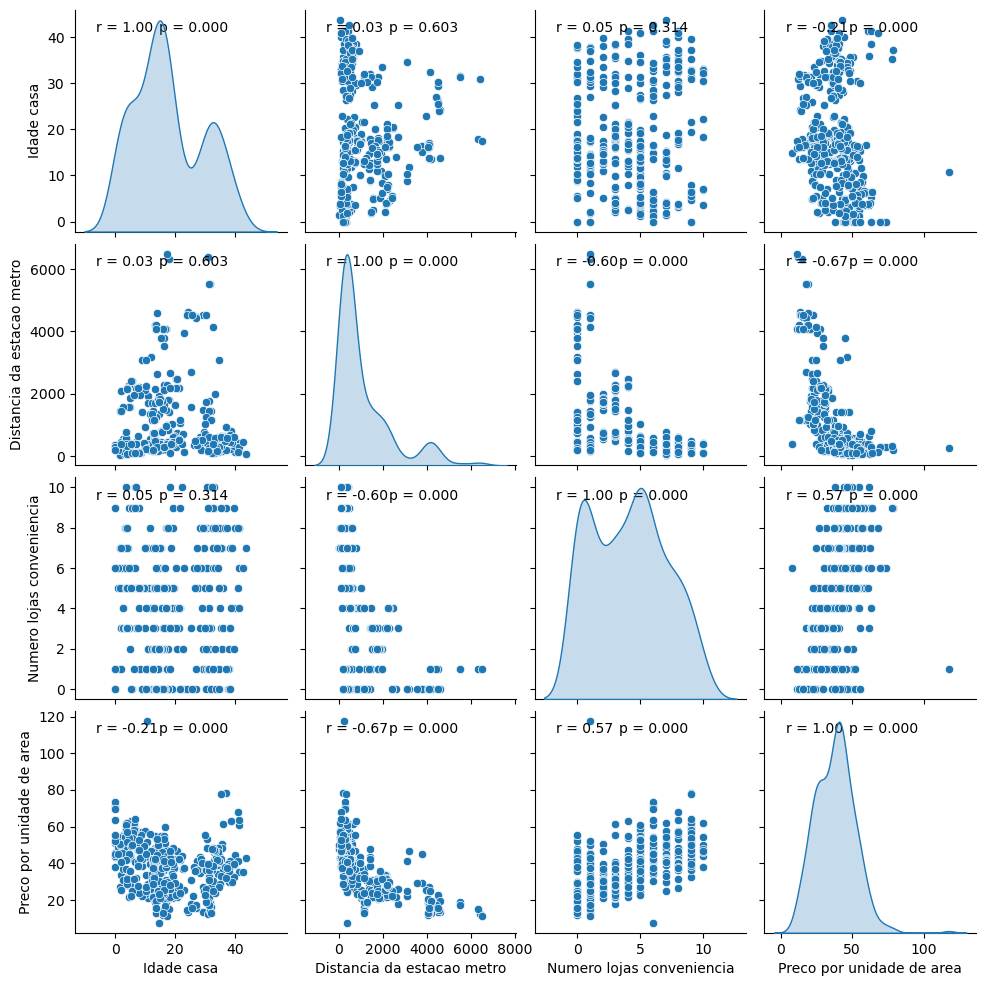

In [19]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y) # r² e p-val
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

plt.figure(figsize=(15,8))
graph = sns.pairplot(df.loc[:,"Idade casa":"Preco por unidade de area"], diag_kind="kde")
graph.map(corrfunc)
plt.show()

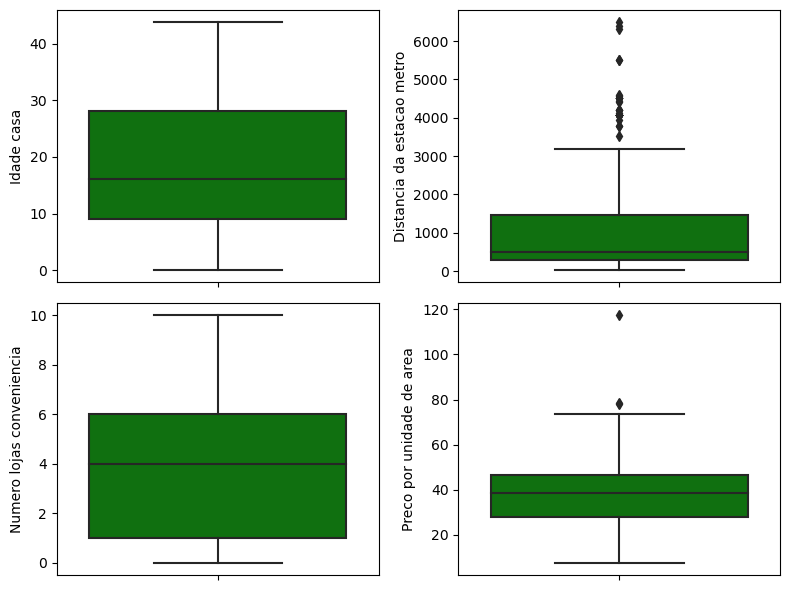

In [20]:
# Boxplot das variáveis quant contínuas
box_columns = ['Idade casa','Distancia da estacao metro', 'Numero lojas conveniencia', 'Preco por unidade de area']
fig, ax = plt.subplots(figsize=(8,6), nrows = 2, ncols = 2)

for i, col in enumerate(box_columns):
    sns.boxplot(y= df[col],ax=ax[i//2, i%2], color = 'green')
fig.tight_layout()



> É possível verificar a presença de alguns outliers nas variáveis 'preco por unidade de area' e 'distancia da estacao'

In [21]:
print(f"Número de outliers na variável 'Distancia da estacao metro': {(stats.zscore(df['Distancia da estacao metro']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Preco por unidade de area'': {(stats.zscore(df['Preco por unidade de area']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Numero lojas conveniencia': {(stats.zscore(df['Numero lojas conveniencia']) > abs(3)).sum()}")
print(f"Número de outliers na variável 'Idade casa': {(stats.zscore(df['Idade casa']) > abs(3)).sum()}")

Número de outliers na variável 'Distancia da estacao metro': 5
Número de outliers na variável 'Preco por unidade de area'': 1
Número de outliers na variável 'Numero lojas conveniencia': 0
Número de outliers na variável 'Idade casa': 0


> No entanto, apesar de ser possível tratar outliers via zscore, não será a melhor alternativa nesse caso, pois as variáveis não estão normalmente distribuídas e ao remover os outliers originais, novos podem aparecer, como exemplificado abaixo.  
> Ao removermos os 5 outliers que tínhamos, 8 novos outliers aparecem.

In [22]:
df_teste = df[(stats.zscore(df['Distancia da estacao metro']) < abs(3))]
print(f"Número de outliers na variável 'Distancia da estacao metro': {(stats.zscore(df_teste['Distancia da estacao metro']) > abs(3)).sum()}")

Número de outliers na variável 'Distancia da estacao metro': 8


> Portanto, iremos fazer por IQR

In [23]:
# Função para tratar outliers

def remove_outliers(df, colunas):
    clean_df = df.copy()
    
    for col in colunas:
        # quartil 1, quartil 3 e IQR
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        # Calcular limites superior e inferior
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar o indice das colunas com outliers para ser removidos posteriormente
        
        outlier_indices = clean_df[(clean_df[col] < limite_inferior) | (clean_df[col] > limite_superior)].index

        # Remove os outliers do dataset nessa coluna
        clean_df.drop(outlier_indices, inplace=True)
    
    return clean_df
        

In [24]:
#Objeto com as colunas a serem tratados
col_outliers = ['Distancia da estacao metro','Preco por unidade de area']
df = remove_outliers(df, col_outliers)

In [25]:
# Não temos todos os meses do ano. Ao inves de separar por mês, talvez seja ideal separar por quarter (trimestre).
df['Mes Transacao'].unique()

array([12,  7,  1, 10,  9,  6,  4,  3])

In [26]:
df.sample(10)

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
286,2012,12,5.9,90.45606,9,56.3
195,2013,4,15.2,461.10160,5,34.6
202,2012,12,38.3,642.69850,3,31.5
238,2013,1,12.8,732.85280,0,40.6
86,2012,10,1.8,1455.79800,1,27.0
359,2013,1,5.6,2408.99300,0,24.7
5,2012,9,7.1,2175.03000,3,32.1
197,2013,1,34.4,126.72860,8,48.2
181,2013,3,11.6,201.89390,8,55.9
227,2012,12,32.4,265.06090,8,40.2


In [27]:
# Transformando a coluna mes em trimestre.
def trimestre_from_mes(mes):
    if mes <= 3:
        return 'Q1'
    elif mes <= 6:
        return 'Q2'
    elif mes <= 9:
        return 'Q3'    
    elif mes <= 12:
        return 'Q4'

df['Mes Transacao'] = df['Mes Transacao'].apply(lambda x: trimestre_from_mes(x))

In [ ]:
# Temos apenas dois anos diferentes
df['Ano Transacao'].value_counts()

In [ ]:
# Correlação
correlacao = df.corr()
sns.heatmap(correlacao, cmap = 'PiYG', annot = True, fmt = '.2f')

In [ ]:
# Visualização das variáveis preditoras
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(12,5))

# Numero de bins
bins = 20

for i, data in enumerate([df['Idade casa'], df['Distancia da estacao metro'], df['Numero lojas conveniencia'], df['Preco por unidade de area']]):
    axs[i].hist(data, bins = bins, alpha = 0.7)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frequencia')
    axs[i].set_title(f'{df.columns[i+2]}')
    
plt.tight_layout()
    
plt.show()

In [ ]:
df.head()

### Dummização das variáveis Ano e Mês

In [ ]:
df_dummies = pd.get_dummies(df, columns=['Ano Transacao', 'Mes Transacao'], drop_first= True)
df_dummies.head()

## Modelo

In [ ]:
# Separando os dados em dados de treino e dados de teste
X = df_dummies.drop('Preco por unidade de area', axis = 1)
y = df_dummies['Preco por unidade de area']

X_train, X_teste, y_train, y_teste = train_test_split(X, y, test_size=0.25)

In [ ]:
# Vamos fazer a padronização dos dados visto que as variáveis se encontram em grandezas diferentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_teste = scaler.transform(X_teste)

In [ ]:
# Verificar se foi devidamente padronizado
print(f'Desvio Padrao: {X_train.std()}')
print(f'Média: {X_train.mean()}')

In [ ]:
# Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

In [ ]:
# Coeficientes
coef = modelo.coef_
pd.DataFrame(data = coef, index = X.columns, columns=['Coeficientes'])

In [ ]:
modelo.intercept_
y_predicted = modelo.predict(X_teste)

In [ ]:
# Plot dos dados previstos com os reais
plt.figure(figsize=(10,8))

plt.scatter(x = y_teste, y = y_predicted, color = 'green', edgecolors= 'black')
plt.xlabel('Valores reais de Y', fontdict={'fontsize': 16})
plt.ylabel('Valores Previstos de Y', fontdict={'fontsize': 16})
plt.grid(True)

In [ ]:
# Métricas de avaliação do modelo
mean_squared_error(y_teste, y_predicted)# Mean Squared Error

In [ ]:
mean_absolute_error(y_teste, y_predicted)# MAE - Mean Absolute Error

In [ ]:
r2_score(y_teste, y_predicted) # R²

## Modelo2

> Modelo para ver resultados estatísticos

In [ ]:
# Será necessário renomear as colunas pra nao ter espaço
X.rename(columns={'Mes Transacao_Q3': 'Mes_Transacao_Q3',
                  'Mes Transacao_Q4': 'Mes_Transacao_Q4',
                  'Mes Transacao_Q2': 'Mes_Transacao_Q2',
                  'Ano Transacao_2013': 'Ano_Transacao_2013',
                  'Idade casa': 'Idade_casa',
                  'Distancia da estacao metro': 'Distancia_da_estacao_metro',
                  'Numero lojas conveniencia': 'Numero_lojas_conveniencia',
                  }, inplace=True)
y = y.rename('Preco_por_unidade_de_area')

In [ ]:
X.columns

In [ ]:
# Padronizar os dados de input(X)
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['Idade_casa', 'Distancia_da_estacao_metro', 'Numero_lojas_conveniencia',
       'Ano_Transacao_2013', 'Mes_Transacao_Q2', 'Mes_Transacao_Q3',
       'Mes_Transacao_Q4'])
X.sample(10)

In [ ]:
X.head()

In [ ]:
# Criando o modelo com a função OLS do o pacote statsmodel
modelo_sm = sm.OLS(y,X).fit()

In [ ]:
# summary do modelo
modelo_sm.summary()

In [ ]:
# Procedimento step wise

# Estimação do modelo por meio do procedimento Stepwise
modelo_sm_stepwise = stepwise(modelo_sm, pvalue_limit=0.05)

In [ ]:
# O modelo 
modelo_sm_stepwise.summary()